# Comparative Performances of all 5 Methods (Double DQN, Dueling DQN, A2C, PID, Human)

## Importing relevant libraries & defining helper functions

In [1]:
import json
import os

import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter


In [2]:
''' Preprocessing function to resize agent's view of the environment & convert it into grayscale '''

def preprocessing(obs, info):
    # convert to grayscale
    obs = cv2.cvtColor(obs, cv2.COLOR_BGR2GRAY)
    # resize to [40,40]
    obs = cv2.resize(obs, (40, 40), interpolation=cv2.INTER_AREA)
    # add new axis to [1,40,40]
    obs = obs[np.newaxis, :]
    # extract values
    info = np.array(list(info.values()))

    info = info / 360
    obs = obs / 255
    return obs, info

''' Preprocessing functions for Double DQN & Dueling DQN '''
deg2rad = np.pi / 180
steering_step1 = 1 * deg2rad
steering_step2 = 2 * deg2rad
steering_step4 = 4 * deg2rad
steering_step8 = 8 * deg2rad
action_map = (
    [1, 0, 0],
    [1, 0, steering_step1],
    [1, 0, -steering_step1],
    [1, 0, steering_step2],
    [1, 0, -steering_step2],
    [1, 0, steering_step4],
    [1, 0, -steering_step4],
    [1, 0, steering_step8],
    [1, 0, -steering_step8],
)
num_actions = len(action_map)
image_size = [1, 1, 40, 40]
data_size = [1, 3]
num_of_episodes = 10000
sync_freq = 1
exp_replay_size = 200
batch_size = 200
count = 0


''' Users specify the number of episodes to test the models on '''
numTestEpisodes = 1



## Double DQN

In [3]:
# import relevant libraries & dependencies for Double DQN 

from common.environment import Environment
from dqn.dqn_agent import DQAgent

# init Environment & Double DQN agent 
env = Environment(randomized=0)
agent = DQAgent(
    env,
    num_of_episodes,
    sync_freq,
    exp_replay_size,
    batch_size,
    num_actions,
    image_size,
    data_size,
)

# init error stat
error_list_DQN = []

pygame 2.0.2 (SDL 2.0.16, Python 3.6.13)
Hello from the pygame community. https://www.pygame.org/contribute.html
Created agent with  9 action space


In [4]:
def doubleDQNTest():
    epsilon = 0
    # load model
    agent.target_net.load_state_dict(torch.load("models/best_dqn.pt"))
    agent.q_net.load_state_dict(torch.load("models/best_dqn.pt"))

    # testing
    for i in range(numTestEpisodes):
        obs, info = env.reset()
        obs, info = preprocessing(obs, info)
        obs = obs[np.newaxis, :]
        info = info[np.newaxis, :]
        done = False
        ep_len, rew = 0, 0

        # init current error stat
        current_error_DQN = []
        while done != True and ep_len < 2000:
            ep_len += 1
            a = agent.get_action(obs, info, num_actions, epsilon)
            obs, reward, done, info = env.step(action_map[a])
            error_trans = info["d_center"]
            obs, info = preprocessing(obs, info)
            obs = obs[np.newaxis, :]
            info = info[np.newaxis, :]
            rew += reward

            # track current error stat 
            current_error_DQN.append(error_trans)
        # track error stats
        error_list_DQN.append(current_error_DQN)

    env.close()

In [5]:
# Let Double DQN agent interact with the environment 
doubleDQNTest()

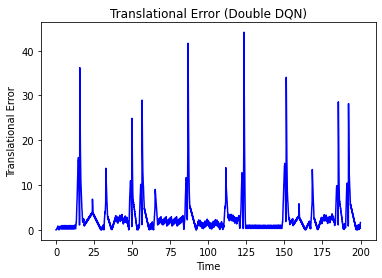

In [6]:
# Translational Error (Double DQN)
x = np.arange(0, 2000*0.1, 0.1)

colors = ['b', 'g', 'r', 'c', 'm']

for y_idx, y in enumerate(error_list_DQN):
    y = np.array(y)

    # to account for cases when controller ends episode earlier than 2000 steps
    if len(y) != 2000:
        y = np.concatenate((y, np.zeros(2000-len(y), dtype='int')))
    plt.plot(x, y, colors[y_idx % len(colors)])
    
plt.title("Translational Error (Double DQN)")
plt.ylabel("Translational Error")
plt.xlabel("Time")
plt.show()


## Dueling DQN

In [7]:
# import relevant libraries & dependencies for Double DQN 

from common.environment import Environment
from ddqn.ddqn_agent import DuelingDQNAgent

sync_freq = 10


# init Environment & Double DQN agent 
env = Environment(randomized=0)
agent = DuelingDQNAgent(
    env,
    num_of_episodes,
    sync_freq,
    exp_replay_size,
    batch_size,
    num_actions,
    image_size,
    data_size,
)

# init error stat
error_list_DDQN = []

Created agent with  9 action space


In [8]:
def duelingDQNTest():
    epsilon = 0
    # load model
    agent.q_net.load_state_dict(torch.load("models/best_ddqn.pt"))

    # testing
    for i in range(numTestEpisodes):
        obs, info = env.reset()
        obs, info = preprocessing(obs, info)
        obs = obs[np.newaxis, :]
        info = info[np.newaxis, :]
        done = False
        ep_len, rew = 0, 0

        # init current error stat
        current_error_DDQN = []
        
        while done != True and ep_len < 2000:
            ep_len += 1
            a = agent.get_action(obs, info, num_actions, epsilon)
            obs, reward, done, info = env.step(action_map[a])
            error_trans = info["d_center"]
            obs, info = preprocessing(obs, info)
            obs = obs[np.newaxis, :]
            info = info[np.newaxis, :]
            rew += reward

            # track current error stat 
            current_error_DDQN.append(error_trans)
        # track error stats
        error_list_DDQN.append(current_error_DDQN)

    env.close()

In [9]:
# Let Dueling DQN agent interact with the environment 
duelingDQNTest()

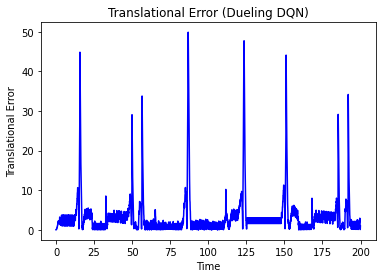

In [10]:
# Translational Error (Dueling DQN)
x = np.arange(0, 2000*0.1, 0.1)
for y_idx, y in enumerate(error_list_DDQN):
    y = np.array(y)

    # to account for cases when controller ends episode earlier than 2000 steps
    if len(y) != 2000:
        y = np.concatenate((y, np.zeros(2000-len(y), dtype='int')))
    plt.plot(x, y, colors[y_idx % len(colors)])
    
plt.title("Translational Error (Dueling DQN)")
plt.ylabel("Translational Error")
plt.xlabel("Time")
plt.show()



## A2C

In [18]:
# import relevant libraries & dependencies for A2C

from common.environment2 import Environment2
from a2c.a2c_agent import A2CAgent

num_actions = 1
image_size = [1, 1, 40, 40]
data_size = [1, 3]
num_of_episodes = 10000
batch_size = 200
beta = 0.001
gamma = 0.95
clip_grad = 0.1
count = 0


# init Environment & A2C agent 
env2 = Environment2(randomized=0)
agent = A2CAgent(
    env, num_of_episodes, beta, gamma, clip_grad, batch_size, num_actions, image_size, data_size
)

# init error stat
error_list_A2C = []

Created agent with  1 action space


In [19]:
def A2CTest():
    agent.net.load_state_dict(torch.load("models/best_a2c.pt"))

    # test
    for i in range(numTestEpisodes):
        obs, info = env2.reset()
        obs, info = preprocessing(obs, info)
        obs = obs[np.newaxis, :]
        info = info[np.newaxis, :]
        done = False
        ep_len, rew = 0, 0

        # init current error stat
        current_error_A2C = []

        while done != True and ep_len < 2000:
            ep_len += 1
            a = agent.get_action(obs, info)
            obs, reward, done, info = env2.step([1, 0, a.squeeze(0)])
            error_trans = info["d_center"]
            obs, info = preprocessing(obs, info)
            obs = obs[np.newaxis, :]
            info = info[np.newaxis, :]
            rew += reward

            # track current error stat 
            current_error_A2C.append(error_trans)
        # track error stats
        error_list_A2C.append(current_error_A2C)

    env2.close()

In [20]:
# Let A2C agent interact with the environment 
A2CTest()

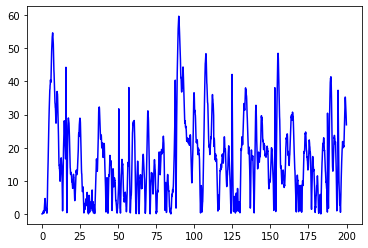

In [24]:
# Translational Error (A2C)
x = np.arange(0, 2000*0.1, 0.1)
for y_idx, y in enumerate(error_list_A2C):
    y = np.array(y)

    # to account for cases when controller ends episode earlier than 2000 steps
    if len(y) != 2000:
        y = np.concatenate((y, np.zeros(2000-len(y), dtype='int')))
    plt.plot(x, y, colors[y_idx % len(colors)])


## PID Controller

In [35]:
from common.environment3 import Environment3

# init helper variables, 
deg2rad = np.pi/180
steering_step = 10*deg2rad

# init environment 
env3 = Environment3()
numTestEpisodes = 1 #10


# PID parameters
Kp = 0.001
Ki = 0.00000000001
Kd = 0.001 
dt = 0.1

# init error stat
error_list_PID = []


In [36]:
def PIDTest():
    # begin driving
    for i in range(numTestEpisodes):
        obs, info = env3.reset()
        done = False
        ep_len, rew = 0, 0
        a = [1, 0, 0]

        # PID variables 
        P_error_trans, I_error_trans, D_error_trans = 0, 0, 0
        # previous error, correction agent needs to make 
        prev_error_trans, corr_trans = 0, 0
        
        # init stats for current error
        current_error = []

        while(done != True and ep_len < 2000):

            # take an action 
            obs, reward, done, info = env3.step(a)
            
            ''' info '''
            velocity = info["velocity"]
            error_trans = info["d_center"]
            error_angle = info["d_angle"]

            ''' PID Controller '''
            # P error (current error)
            P_error_trans = error_trans

            # I error (cumulative error) 
            # anti-windup for I error (when the controller has reached the setpoint, reset I error to 0) 
            if np.abs(error_trans) <= 0.1:
                I_error_trans = 0
            # else continue accumulating error 
            else:
                I_error_trans = I_error_trans + error_trans

            # D error (difference in errors)
            D_error_trans = (error_trans - prev_error_trans)/dt 

            # PID control algo
            corr_trans = Kp*P_error_trans + Ki*I_error_trans + Kd*D_error_trans

            ''' Controller determines next action to take '''
            # determine next action to take 
            a = [1, 0, corr_trans]

            ''' Variable updating & Error tracking '''
            # updating of variables 
            prev_error_trans = error_trans
            ep_len += 1
            rew  += reward
        
            # track current error stats
            current_error.append(error_trans)
        
        # track stats
        error_list_PID.append(current_error)

    env3.close()

In [37]:
# Let PID Controller interact with the environment 
PIDTest()

## Human

In [58]:
from common.environment import Environment

env4 = Environment(randomized=0)

ep_len = 0
done = False

# init error stat
error_list_Human = []

def humanTest():
    for i in range(numTestEpisodes):
        ep_len = 0
        done = False
        current_error_Human = []
        
        while done != True and ep_len < 2000:
            action = env4.policy()

            obs, reward, done, info = env4.step(action)
            error_trans = info["d_center"]

            # print(reward, info)

            # track current error stat 
            current_error_Human.append(error_trans)

            if done:
                env4.reset()
            cv2.imshow("Observation Space", obs)
            cv2.waitKey(1)

            ep_len+=1 

        # track error stats
        error_list_Human.append(current_error_Human)

        env4.close()



In [59]:
'''
now it's your turn to play! 
(& see how badly/well you perform)
'''

# Let Human interact with the environment 
humanTest()

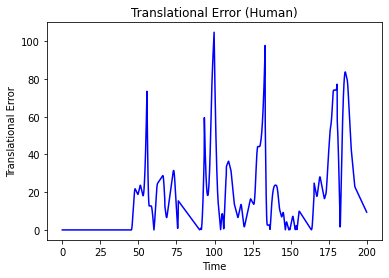

In [52]:
# Translational Error (Human)
x = np.arange(0, 2000*0.1, 0.1)

colors = ['b', 'g', 'r', 'c', 'm']

for y_idx, y in enumerate(error_list_Human):
    y = np.array(y)

    # to account for cases when controller ends episode earlier than 2000 steps
    if len(y) != 2000:
        y = np.concatenate((y, np.zeros(2000-len(y), dtype='int')))
    plt.plot(x, y, colors[y_idx % len(colors)])
    
plt.title("Translational Error (Human)")
plt.ylabel("Translational Error")
plt.xlabel("Time")
plt.show()

# Comparison between all 5 methods 

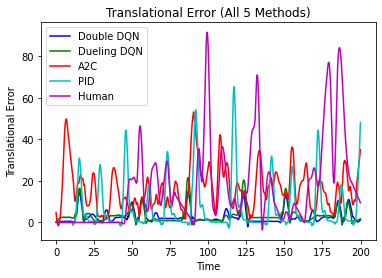

In [54]:
'''

important note:
each of the error_list_{model} in error_list_main is 
a *list of lists*. This is so users may specify the number 
of testing episodes to run all these models on & whether on the
same or new environment each episode.

The number of episodes to test for is defined in variable 

'''

error_list_main = {
    "Double DQN": error_list_DQN,
    "Dueling DQN": error_list_DDQN,
    "A2C": error_list_A2C,
    "PID": error_list_PID,
    "Human": error_list_Human
}

colors = ['b', 'g', 'r', 'c', 'm']

# for i in range(numTestEpisodes):
for idx, error_list_key in enumerate(error_list_main):
    if error_list_key == "PID":
        plt.plot(x, savgol_filter(np.abs(error_list_main[error_list_key][0]), 51, 2), colors[idx], label=error_list_key)
    else:
        plt.plot(x, savgol_filter(error_list_main[error_list_key][0], 51, 2), colors[idx], label=error_list_key)

plt.title("Translational Error (All 5 Methods)")
plt.ylabel("Translational Error")
plt.xlabel("Time")
plt.legend(loc="upper left")
plt.show()


## Saving the training data into `.json` files

In [57]:
'''

important note:
each of the error_list_{model} in error_list_json is 
a *list of lists*. This is so users may specify the number 
of testing episodes to run all these models on & whether on the
same or new environment each episode.

The number of episodes to test for is defined in variable 

'''

error_list_json = {
    "dqn": error_list_DQN,
    "ddqn": error_list_DDQN,
    "a2c": error_list_A2C,
    "pid": error_list_PID,
    "human": error_list_Human
}

for id, key in enumerate(error_list_json):
    with open(f"errors/{key}_errors.json", "w") as f:
        errors = {
            "errors": error_list_json[key],
        }
        json.dump(errors, f, indent=2)


    